In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

In [2]:
train_data = pd.read_csv('../data/raw/train.csv')
target = train_data['Target']
target.shape

(909604,)

In [3]:
train_data.columns

Index(['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'turbine_id', 'Target'],
      dtype='object')

In [4]:
# no rel fts used...

knn_tr_oof = pd.read_csv('../submissions/knn-3_train_cv.csv')
knn_te_oof = pd.read_csv('../submissions/knn-3_test_cv.csv')

# xt_50_tr_oof = pd.read_csv('../submissions/extratree reg 50_train_cv.csv')
# xt_50_te_oof = pd.read_csv('../submissions/extratree reg 50_test_cv.csv')

xt_65_tr_oof = pd.read_csv('../submissions/extratree reg 65_train_cv.csv')
xt_65_te_oof = pd.read_csv('../submissions/extratree reg 65_test_cv.csv')

lr_pf_tr_oof = pd.read_csv('../submissions/lr_pf_train_cv.csv')
lr_pf_te_oof = pd.read_csv('../submissions/lr_pf_test_cv.csv')

xgb_tr_oof = pd.read_csv('../submissions/baseline xgb_train_cv.csv')
xgb_te_oof = pd.read_csv('../submissions/baseline xgb_test_cv.csv')

lgb_tr_oof = pd.read_csv('../submissions/baseline lgb_train_cv.csv')
lgb_te_oof = pd.read_csv('../submissions/baseline lgb_test_cv.csv')

cb_tr_oof = pd.read_csv('../submissions/baseline cb_train_cv.csv')
cb_te_oof = pd.read_csv('../submissions/baseline cb_test_cv.csv')

# rel fts used...
xt_50_rel_tr_oof = pd.read_csv('../submissions/train_xt_50_rel_fts_v1_oof.csv')
xt_50_rel_te_oof = pd.read_csv('../submissions/test_xt_50_rel_fts_v1_oof.csv')

lr_rel_tr_oof = pd.read_csv('../submissions/train_lr_rel_fts_v1_oof.csv')
lr_rel_te_oof = pd.read_csv('../submissions/test_lr_rel_fts_v1_oof.csv')

xgb_rel_tr_oof = pd.read_csv('../submissions/train_xgb_rel_fts_v1_oof.csv')
xgb_rel_te_oof = pd.read_csv('../submissions/test_xgb_rel_fts_v1_oof.csv')

In [5]:
tr = pd.concat([knn_tr_oof, xt_65_tr_oof, lr_pf_tr_oof, xgb_tr_oof, cb_tr_oof, lgb_tr_oof, xt_50_rel_tr_oof, lr_rel_tr_oof, xgb_rel_tr_oof], axis=1)
te = pd.concat([knn_te_oof, xt_65_te_oof, lr_pf_te_oof, xgb_te_oof, cb_te_oof, lgb_te_oof, xt_50_rel_te_oof, lr_rel_te_oof, xgb_rel_te_oof], axis=1)

tr.shape, te.shape

((909604, 9), (303202, 9))

In [6]:
tr.columns = ['knn', 'xt_65', 'lr_pf', 'xgb', 'cb', 'lgb', 'xt_50_rel', 'lr_rel', 'xgb_rel']
te.columns = ['knn', 'xt_65', 'lr_pf', 'xgb', 'cb', 'lgb', 'xt_50_rel', 'lr_rel', 'xgb_rel']

tr.head()

,knn,xt_65,lr_pf,xgb,cb,lgb,xt_50_rel,lr_rel,xgb_rel
0,47.062932,47.052426,46.703342,45.965927,46.340031,46.381442,46.605309,46.855619,46.604042
1,45.975586,46.393675,45.801777,46.238602,45.943689,45.985656,46.132662,45.734109,45.794102
2,40.060520,40.104322,40.504172,40.534119,41.232814,40.481437,40.121551,40.900952,40.056274
3,46.291268,45.992248,45.118535,45.769348,46.119833,46.276130,45.908263,45.442595,46.351139
4,55.366199,54.049326,50.370361,55.147987,53.502856,54.149239,55.169074,49.447344,55.323101


<AxesSubplot:>

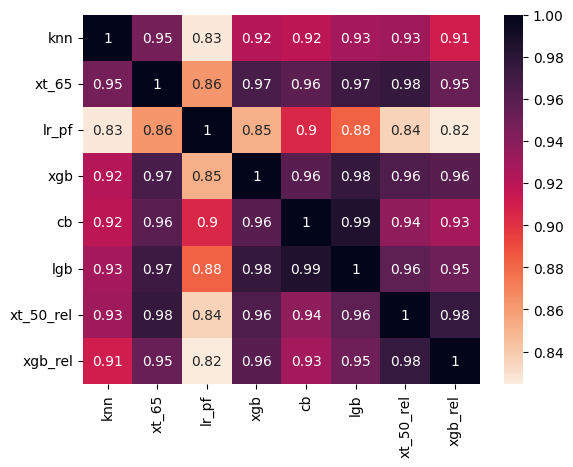

In [179]:
sns.heatmap(tr.drop('lr_rel', axis=1).corr(), annot=True, cmap='rocket_r')

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(tr, target, test_size=0.2, random_state=4567)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((727683, 9), (181921, 9), (727683,), (181921,))

In [8]:
X_train.columns

Index(['knn', 'xt_65', 'lr_pf', 'xgb', 'cb', 'lgb', 'xt_50_rel', 'lr_rel',
       'xgb_rel'],
      dtype='object')

In [9]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [10]:
xgb = XGBRegressor(n_estimators=1000, tree_method='gpu_hist', gpu_id=0)
lgb = LGBMRegressor(n_estimators=1000)
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=10)
xt = ExtraTreesRegressor(n_estimators=10)
cb = CatBoostRegressor(verbose=1000, n_estimators=1000)

In [12]:
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)
print(mape(y_val, lr_preds))

0.010654454579451718


In [13]:
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_val)
print(mape(y_val, xgb_preds))

0.010755865973035574


In [14]:
cb.fit(X_train, y_train)
cb_preds = cb.predict(X_val)
print(mape(y_val, cb_preds))

Learning rate set to 0.115976
0:	learn: 2.3678157	total: 246ms	remaining: 4m 6s
999:	learn: 0.7622257	total: 1m 43s	remaining: 0us
0.010589519108515416


In [15]:
lgb.fit(X_train, y_train)
lgb_preds = lgb.predict(X_val)
print(mape(y_val, lgb_preds))

0.010594439467791806


In [16]:
xt.fit(X_train, y_train)
xt_preds = xt.predict(X_val)
print(mape(y_val, xt_preds))

0.011379223925630073


In [17]:
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
print(mape(y_val, rf_preds))

0.011344509998713065


In [18]:
# sns.heatmap([lr_preds, xgb_preds, lgb_preds, rf_preds], annot=True)

In [128]:
mape(tr['xt_65', 'xt_50_rel'].mean(axis=1), target)

0.014899396344141657

In [172]:
all_preds = [lr_preds, xgb_preds, lgb_preds, cb_preds, rf_preds]
all_preds = np.array(all_preds)
all_preds.shape

(4, 181921)

In [173]:
mape(all_preds.mean(axis=0), y_val)

0.01063067879330411

In [175]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mape)

cv = cross_val_score(lr, all_preds.reshape(-1, 4), y_val, cv=5, scoring=mape_scorer)
cv, cv.mean()

(array([0.04092107, 0.04108201, 0.04085245, 0.04099423, 0.04109068]),
 0.040988086528216915)

In [195]:
x = all_preds.mean(axis=0)
mydf = pd.DataFrame(x, index=X_val.index, columns=['Target'])
mydf

,Target
878743,40.743350
359531,47.509548
284191,46.539162
188980,45.845334
776594,46.273487
...,...
57321,46.398241
674088,46.233584
569434,48.534585
619893,51.843482


In [196]:
mydf.columns

Index(['Target'], dtype='object')

In [202]:
test_df = pd.read_csv('../data/raw/test.csv')
test_df.shape

(303202, 15)

In [203]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303202 entries, 0 to 303201
Data columns (total 15 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   timestamp                               303202 non-null  object 
 1   active_power_calculated_by_converter    303202 non-null  float64
 2   active_power_raw                        303202 non-null  float64
 3   ambient_temperature                     303202 non-null  float64
 4   generator_speed                         303202 non-null  float64
 5   generator_winding_temp_max              303202 non-null  float64
 6   grid_power10min_average                 303202 non-null  float64
 7   nc1_inside_temp                         303202 non-null  float64
 8   nacelle_temp                            303202 non-null  float64
 9   reactice_power_calculated_by_converter  303202 non-null  float64
 10  reactive_power                          3032